<a href="https://colab.research.google.com/github/BlackHole3344/FineTune/blob/main/Learning_RateSchedular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.functional as F
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler
import math
from typing import List
from torch.utils.data import Dataset , DataLoader

In [ ]:
class LRWS(LRScheduler) :

  def __init__(self ,
               optimizer ,
               total_steps : int ,
               warmup_decay_type : str = "linear" ,
               train_decay_type : str = "linear" ,
               warmup_steps : int = 1000 ,
               min_lr: flo at = 1e-7 ,
               last_epoch : int = -1):

    self.warmup_decay_type = warmup_decay_type
    self.train_decay_type = train_decay_type
    self.warmup_steps = warmup_steps
    self.total_steps = total_steps
    self.min_lr = min_lr
    self.optimzer = optimizer
    self.initial_lr = [group["lr"] for group in self.optimizer.param_groups]

    super().__init__(optimizer , last_epoch)


    def warmup_decay(self , step ):
      if self.warmup_decay_type == "linear" :
        return float(step / self.warmup_steps)

      else :
        progress = float(step / self.warmup_steps)
        return float(0.5 * (1.0 + math.cos(math.pi * progress)))

    def train_decay(self , step) :

      progress = float((step - warmup_steps)/float (max(1 ,self.total_steps - self.warmup_steps)))
      if self.train_decay_type == "linear" :
        return float(1.0 - progress)
      if self.train_decay_type == "cosine" :
        return float(0.5 * (1.0 + math.cos(math.pi * progress)))


    def get_lr(self) -> List[int] :
      step  = self.last_epoch + 1

      if step < self.warmup_steps:
         decay_factor = self.warmup_decay(step)

      else :
        decay_factor = self.train_decay(step)

      return [max(self.min_lr , base_lr * decay_factor) for base_lr in self.initial_lr]


class LRMonitor:
    def __init__(self):
        self.learning_rates = []
        self.steps = []

    def update(self, step: int, lr: float):
        self.steps.append(step)
        self.learning_rates.append(lr)

    def plot(self):
        import matplotlib.pyplot as plt
        plt.plot(self.steps, self.learning_rates)
        plt.xlabel('Step')
        plt.ylabel('Learning Rate')
        plt.title('Learning Rate Schedule')
        plt.show()



In [ ]:
class TripletDataloader(Dataset) :
  def __init__(self , base_model , data  , negative_sampler) :
    self.base_model = base_model
    self.data = data
    self.negative_sampler = negative_sampler

  def __len__(self) :
    return len(self.data)

  def __getitem__(self , idx) :
    item = self.data[idx]
    query = self.model.encode(item["query"] , convert_to_tensor = True)
    positive = self.model.encode(item["chunk"] , convert_to_tensor = True)
    negative = self.model.encode(self.negative_sampler(query) , convert_to_tensor = True)
    return query , positive , negative


In [ ]:
class Trainer :
  def __init__(self , lr_schedular ,dataset , epochs , base_model , Linear_adapter : nn.Module , margin : int = 0.2 , batch_size : int = 32):

    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.lr_schedular = lr_schedular
    self.base_model = base_model
    self.epochs = epochs
    self.adapter = Linear_adapter(base_model.get_sentence_embedding_dimension()).to(self.device)
    self.loss = nn.TripletMarginLoss(margin=margin , p=2.0)
    self.dataloader = DataLoader(dataset , batch_size = batch_size)
    self.optimizer = torch.optim.AdamW(self.adapter.parameters(), lr=0.001)
    self.total_steps  = epochs * len(dataset)
    #########################################


  def train(self):
    for i in range(self.epochs) :
      for batch in self.dataloader :
        query , positive , negative = batch
        query = query.to(self.device)
        positive = positive.to(self.device)
        negative = negative.to(self.device)
        loss = self.loss(self.adapter(query) , self.adapter(positive) , self.adapter(negative))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.lr_schedular.step()






In [ ]:
!pip install trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.3/318.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:


class basenet(nn.Module) :
  def __init__(self , x = 100) :
    super().__init__()
    self.layer1 = nn.Linear(x , 20)
    self.layer2 = nn.Linear(20 , 1)

  def forward(self , x ) :
    x = self.layer1(x)
    x  =  F.norm(x)
    return self.layer2(x)



model = basenet()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

In [ ]:
optimizer.param_groups[0]["lr"]

0.01

In [ ]:
# Assume:
total_steps = 1000
warmup_steps = 100
initial_lr = 0.001

import matplotlib.pyplot as plt

def decay_examples(steps_size):
    def linear_decay(step):
        progress = (step - 100) / (steps_size - 100)
        return 1.0 - progress

    def cosine_decay(step):
        progress = (step - 100) / (steps_size - 100)
        return 0.5 * (1.0 + math.cos(math.pi * progress))

    steps = [i for i in range(steps_size)]
    lr = []
    cosine_lr =[]

    for step in steps:
        linear_factor = linear_decay(step)
        cosine_factor = cosine_decay(step)


        lr.append(linear_factor)
        cosine_lr.append(cosine_factor)

    return lr , cosine_lr



In [ ]:
from trl import Trainer


ImportError: cannot import name 'Trainer' from 'trl' (/usr/local/lib/python3.11/dist-packages/trl/__init__.py)

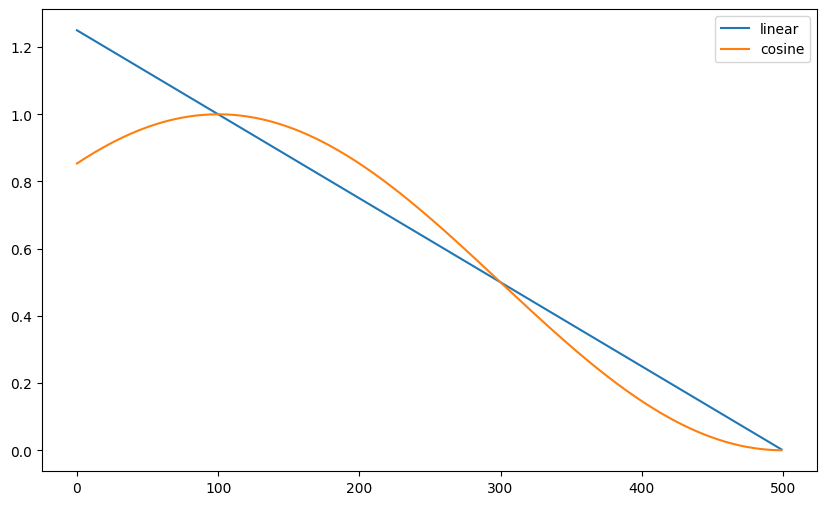

In [ ]:
lr , cosine_lr = decay_examples(500)
plt.figure(figsize=(10, 6))
plt.plot(lr)
plt.plot(cosine_lr)
plt.legend(["linear" , "cosine"])